Target distribution:
target
0.0    789400
1.0     10600
Name: count, dtype: int64
y_train distribution:
target
1.0    8498
0.0    8462
Name: count, dtype: int64
Starting Randomized Search...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters:  {'colsample_bytree': 0.7123738038749523, 'gamma': 0.27134804157912423, 'learning_rate': 0.052277267492428794, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 138, 'subsample': 0.9947547746402069}
Prediction results saved to predicted_results_xgboost_optimized.xlsx
Classification report on test set:
               precision    recall  f1-score   support

         0.0       0.84      0.85      0.84      2138
         1.0       0.84      0.83      0.84      2102

    accuracy                           0.84      4240
   macro avg       0.84      0.84      0.84      4240
weighted avg       0.84      0.84      0.84      4240

Test set AUC score: 0.9140446222983323
Code run time: 78.64 seconds


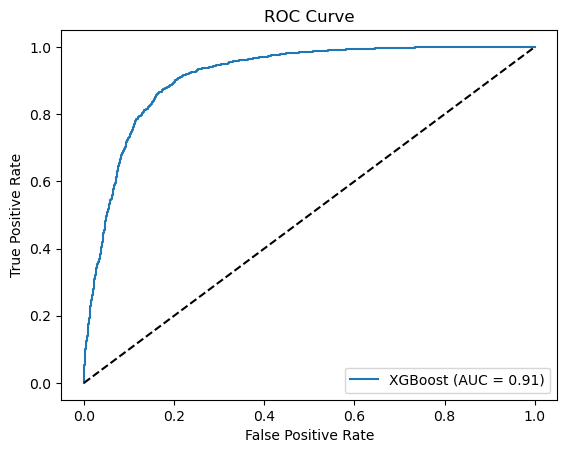

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import time
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

# Record start time
start_time = time.time()

# Load dataset
data = pd.read_csv('train.csv')

# Check the distribution of the target variable
print("Target distribution:")
print(data['target'].value_counts())

# Extract positive and negative samples
positive_samples = data[data['target'] == 1]
negative_samples = data[data['target'] == 0]

# Balance the dataset by upsampling the minority class
minority_class = positive_samples
majority_class = negative_samples.sample(n=len(positive_samples), replace=True, random_state=42)
balanced_data = pd.concat([majority_class, minority_class])

# Split the dataset into features (X) and target (y)
X = balanced_data.drop(['id', 'target'], axis=1)
y = balanced_data['target']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the distribution of y_train
print("y_train distribution:")
print(y_train.value_counts())

# Define the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'min_child_weight': randint(1, 10)
}

# Perform Randomized Search to optimize hyperparameters
print("Starting Randomized Search...")
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=100, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

# Output the best parameters
print("Best parameters: ", random_search.best_params_)

# Train the model with the best parameters
best_model = random_search.best_estimator_

# Predict probabilities for unknown users
unknown_users = data[data['target'] == 0].drop(['id', 'target'], axis=1)
unknown_users_scaled = scaler.transform(unknown_users)
predicted_probabilities = best_model.predict_proba(unknown_users_scaled)[:, 1]  # Get the probabilities for being a 5G user

# Set a threshold to determine which users are likely 5G users
threshold = 0.6  # This threshold can be adjusted
predicted_labels = (predicted_probabilities > threshold).astype(int)

# Save the results
results = pd.DataFrame({
    'id': data[data['target'] == 0]['id'],
    'predicted_target': predicted_labels
})
results.to_excel('predicted_results_xgboost_optimized.xlsx', index=False)

print("Prediction results saved to predicted_results_xgboost_optimized.xlsx")

# Evaluate the model performance on the test set
y_test_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_prob > threshold).astype(int)
print("Classification report on test set:\n", classification_report(y_test, y_test_pred))
auc_score = roc_auc_score(y_test, y_test_pred_prob)
print("Test set AUC score:", auc_score)

# Record end time and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Code run time: {elapsed_time:.2f} seconds")

# Plot the ROC curve for the best model
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()
